In [ ]:
!pip install imblearn
!pip install category_encoders

In [1]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = 'all' # to see multiple lines of output in one cell
import pandas as pd #data manipulation
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer,LabelEncoder
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load the datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#Data is split into train and test here, if not we can use K-fold cross validation to split the dataset into train, test and validation

In [ ]:
# Exploratory data analysis
train.describe() #describe numerical variables
train.describe(include='object') #describe cat variables

#check dimensions of data
train.shape
test.shape

#check if data has duplicate rows
train.duplicated().sum() #no duplicate observations

#check for % of missing data in each variable
train.isna().sum()/len(train)

In [3]:
#seperate variables into cat and num
numerical= train.select_dtypes(include = 'number').columns
categorical = train.select_dtypes(include = 'object').columns

In [ ]:
#Univariate analysis

for i in categorical:
    fig, ax = plt.subplots(1,1, figsize=(15, 6))
    sns.barplot(x=i, y="total_night_minutes", data=train, estimator=lambda i: len(i) / len(train) * 100)
    fig.text(0.1, 0.95, f'{i}', fontsize=16, fontweight='bold', fontfamily='serif')
    plt.xlabel(i, fontsize=20)
    plt.ylabel('Percent')
    plt.yticks(fontsize=13)
    plt.box(False)
#90.7% customers didn't have international plan
#73.8% customers didn't have voice mail plan
#49.6% customers are living in the area code area_code_415.
#only 14.1% customers are churn

In [ ]:
#Numerical variables
train.hist(column=numerical,bins=50,figsize=(20,20),color='navy')

In [ ]:
#Number_customer_service_calls, total_internation_call and Number_voice_mail_messages are not a normal distribuation so we can covert into normally distributed

#BIVARIATE ANALYSIS:

#check for multicollinearity
plt.figure(figsize=(16, 8))
sns.heatmap (train[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm');

#As expected the minute variables are correlated with the charge variables - we will treat for multicollinearit in the feature engineering section


In [ ]:
#cat vs cat
# plot bars in stacked manner
cats=train.select_dtypes(include = 'object').columns.drop("churn")
for i in cats:
    train_plot=train.groupby(['churn',i]).size().reset_index().pivot(columns='churn',index=i,values=0)
    train_plot.plot(kind='bar',stacked=True,figsize=(15,10))
    del train_plot

In [ ]:
#cat vs cont
fig, axes = plt.subplots(8, 2,figsize=(15,15))
count=0
for num in numerical:
        sns.boxplot(x ='churn', y = num, data = train,ax=axes.flatten()[count],orient='v')
        count+=1
        
fig.delaxes(axes[7,1]) # remove empty subplot     

In [ ]:

for i in numerical:
    x1 = train.loc[train.churn=='no'][i]
    x2 = train.loc[train.churn=='yes'][i]
    kwargs = dict(alpha=0.5,bins=10)
    count,edges,bars=plt.hist(x1, **kwargs, color='g', label='no')
    plt.bar_label(bars)
    count,edges,bars=plt.hist(x2, **kwargs, color='b', label='yes')
    plt.bar_label(bars)
    plt.title(f"Frequency histogram of %s" %i)
    plt.legend()
    plt.show()
    del x1,x2,count,edges,bars


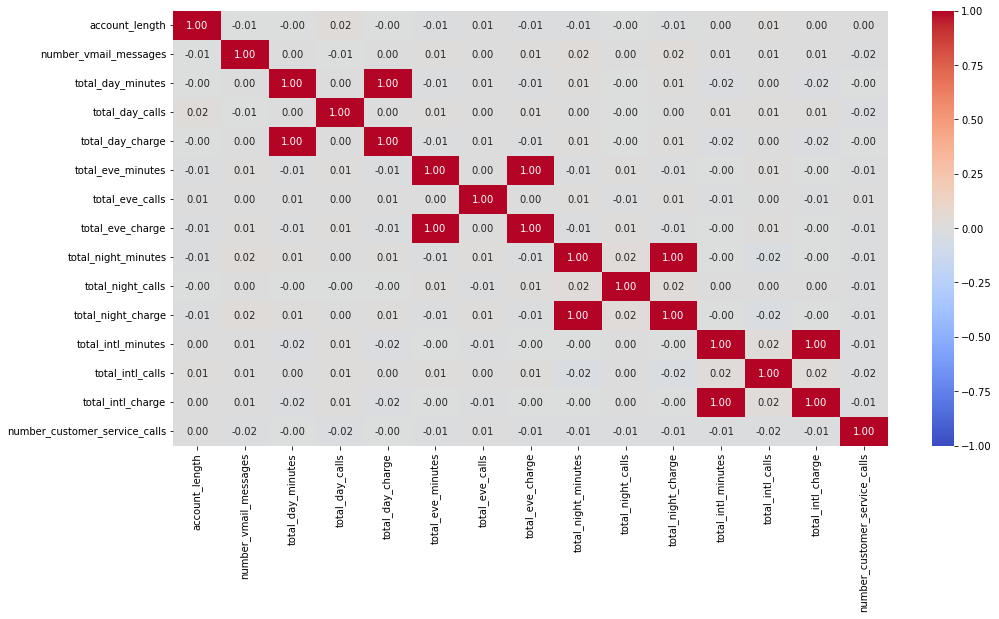

In [ ]:
#FEATURE ENGINEERING

#check for multicollinearity
plt.figure(figsize=(16, 8))
sns.heatmap (train[numerical].corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm');
#charge and call minute variables are perfeclty correlated. This is as expected since total charge is calculated as a product of call minutes & charge per min.
#Hence we can drop the call minutes variable  
drop_col = ["total_day_minutes", "total_eve_minutes", "total_night_minutes", "total_intl_minutes"]
train = train.drop(drop_col, axis=1)
numerical= train.select_dtypes(include = 'number').columns #update numerical list

In [ ]:
train[categorical].nunique() #All categorical variables except area_code have only a few levels.
#Variables with only 2 levels can be coded as 0 and 1,
#variables with 3 levels can be dummy coded using one hot encoding technique
#since State has 51 levels using one hot encoding would create too many variables which would eventually result in overfitting.
#Hence we can use hash encoding here
train['churn'] = train['churn'].map(lambda x: 0 if x == 'no' else 1) 
train['international_plan']=train['international_plan'].map(lambda x:0 if x=='no' else 1)
train['voice_mail_plan']=train['voice_mail_plan'].map(lambda x:0 if x=='no' else 1)
test['international_plan']=test['international_plan'].map(lambda x:0 if x=='no' else 1)
test['voice_mail_plan']=test['voice_mail_plan'].map(lambda x:0 if x=='no' else 1)

#use one hot encoding to convert area code to dummy
train=pd.get_dummies(train,columns=['area_code'],drop_first=True)
test=pd.get_dummies(test,columns=['area_code'],drop_first=True)

#state variable has 51 values, conversion using one hot will create too many variables. hence use hash encoding
hash_state = ce.HashingEncoder(cols = 'state')
train = hash_state.fit_transform(train)
test = hash_state.fit_transform(test)


features=train.columns.drop("churn")
target="churn"
from sklearn.model_selection import train_test_split
x_train, x_test,y_train,y_test = train_test_split(train[features],train[target], test_size=0.2, stratify=train[target], random_state=888)



In [38]:
#count levels in target variable
y_train.value_counts()
y_test.value_counts()

0    2922
1     478
Name: churn, dtype: int64

In [39]:

#HANDLING IMBALANCED DATA: 

#weighing classes differently
from sklearn.utils import compute_class_weight
weights = compute_class_weight('balanced', classes=y_train.unique(), y=y_train)
weights
#This means that if we want the dataset to be balanced, we need to weigh the majority class at 0.58187295 and the minority class at 3.55351171. So a much higher weight for the minority class.

array([0.58179329, 3.55648536])

In [40]:
#testing to see if weights balanced
print((y_train == 0).sum()*weights[0])
print((y_train == 1).sum()*weights[1])
#The different weights make it cost more to misclassify a minority class than the majority class.
#This supports our goal of classifying the minority class.

1700.0
1700.0


In [ ]:
#data scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train))
x_test = pd.DataFrame(scaler.transform(x_test))


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.757576,0.0,...,0.805556,0.435294,0.452521,0.500000,0.416019,0.3,0.359259,0.111111,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.341991,0.0,...,0.520080,0.652941,0.638179,0.366197,0.781829,0.1,0.564815,0.111111,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.212121,0.0,...,0.609605,0.323529,0.806483,0.683099,0.778243,0.2,0.529630,0.111111,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.311688,0.0,...,0.687584,0.782353,0.468893,0.626761,0.394501,0.1,0.555556,0.222222,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.290043,0.0,...,0.681392,0.617647,0.567125,0.260563,0.389121,0.3,0.494444,0.000000,1.0,0.0


In [54]:
from sklearn.ensemble import RandomForestClassifier
#random forest
rf_weighted = RandomForestClassifier(random_state=888)
rf_weighted.fit(x_train, y_train)
y_pred = rf_weighted.predict_proba(x_test)[:, 1]
roc_auc_score(y_test, y_pred)

0.9453310502283105

In [ ]:

#1) Oversampling:

#random oversampling
#from imblearn.over_sampling import RandomOverSampler
#ros = RandomOverSampler(random_state=888)
#X_resampled, y_resampled = ros.fit_resample(train[features], train[target])
#y_resampled.value_counts()

#from sklearn.linear_model import LogisticRegression
#mod = LogisticRegression(random_state=888)

#mod.fit(X_resampled, y_resampled)
#y_pred = clf.predict_proba(test_encided[features])[:, 1]

#from sklearn.metrics import roc_auc_score
#roc_auc_score(test_encoded['churn'], y_pred)
#SMOTE oversampling

#lable
#from imblearn.over_sampling import SMOTENC
#smote = SMOTE(random_state=888)
#X_resampled, y_resampled = smote.fit_resample(encoded_data, train[target])
#y_resampled.value_counts()
#smotenc=SMOTENC(random_state=42, categorical_features=categorical)
#X_resampled, y_resampled = smotenc.fit_resample(train[features], train[target])